# FEL power calculation based on Ming Xie parametrization for LCLS

In [1]:
import numpy as np
import os

# openPMD-beamphysics
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import twiss_match, matched_particles
from pmd_beamphysics.statistics import slice_statistics, twiss_dispersion_calc
from pmd_beamphysics.plot import slice_plot, marginal_plot, density_and_slice_plot
from h5py import File

# Bessel functions
from scipy.special import j0, j1
from scipy import constants

# nicer plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)
plt.rcParams.update({'font.size': 14})

# useful for debugging
%load_ext autoreload
%autoreload 2

# constants
m_e = constants.value('electron mass energy equivalent in MeV')
e = constants.e
c = constants.c
hc = constants.h*c /constants.nano /constants.eV # eV.nm

## Import electron bunch beam data from Bmad

In [2]:
# create ParticleGroup from bmad h5 particle data
directory = '../beam_undulator_data/'

# Beam data along undulator
P_data= {}

for filename in os.listdir(directory):
    # change file name when needed
    if filename.endswith("10k.h5"): 
        marker = filename[10:-18]
        P_data[f"{marker}"] = ParticleGroup(directory+filename)     

In [3]:
# collimation loses some particles, take only alive particles here
for beam in P_data:
    P_data[beam] = P_data[beam].where(P_data[beam].status==1) # status 1 is alive

## Plot bunch to see energy spread etc

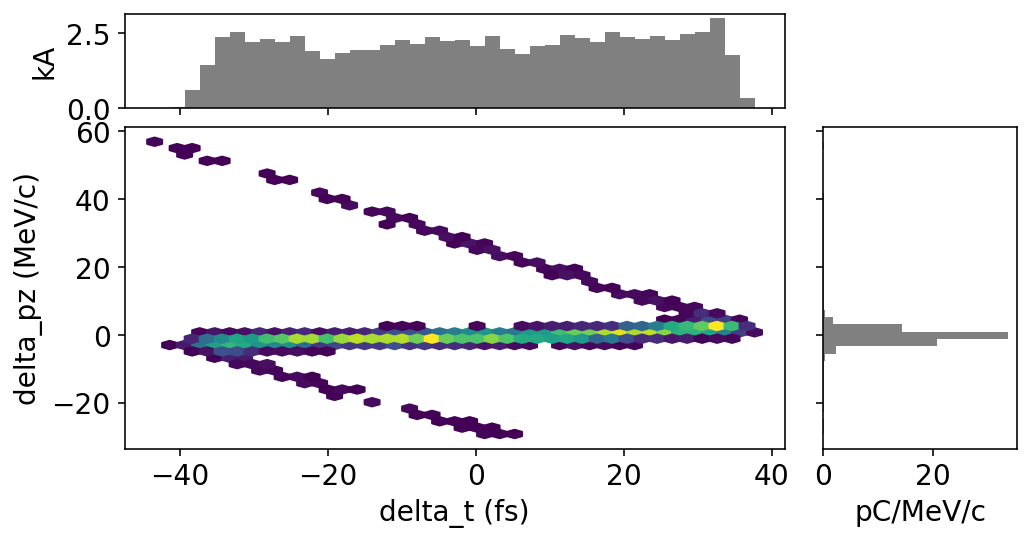

In [4]:
P_data['10_VVHXU15'].plot('delta_t', 'delta_pz')

# last 4 markers before and including ENDUNDH show beam curvature
# energy spread is large because of the weird line shaped horns, not fixed yet 

## Getting slice statistics: avg current, energy spread, beam size

Formulas for Twiss from: https://uspas.fnal.gov/materials/19Knoxville/g-2/creation-and-analysis-of-beam-distributions.html 

In [5]:
# from bmad LCLS lattice
# all markers along undulator where beam data is being saved
markers = ['BEGUNDH', 'MM3', 'PFILT1', 'DBMARK37', 'HXRSTART', 'MBLMH13', 'VVHXU13','MBLMH14','VVHXU14','MBLMH15',\
           'VVHXU15','MBLMH16','VVHXU16','MBLMH17','VVHXU17','MBLMH18','VVHXU18','MBLMH19','VVHXU19','MBLMH20',\
           'VVHXU20','MBLMH21','MBLMH22','VVHXU22','MBLMH23','VVHXU23','MBLMH24','VVHXU24','MBLMH25','VVHXU25',\
           'MBLMH26','VVHXU26','MBLMH27','VVHXU27','HXRSSBEG','HXRSSEND','MBLMH28','MBLMH29','VVHXU29','MBLMH30',\
           'VVHXU30','MBLMH31','VVHXU31','MBLMH32','VVHXU32','MBLMH33','VVHXU33','MBLMH34','VVHXU34','MBLMH35',\
           'VVHXU35','MBLMH36','VVHXU36','MBLMH37','VVHXU37','MBLMH38','VVHXU38','MBLMH39','VVHXU39','MBLMH40',\
           'VVHXU40','MBLMH41','VVHXU41','MBLMH42','VVHXU42','MBLMH43','VVHXU43','MBLMH44','VVHXU44','MBLMH45',\
           'MPHH','VVHXU45','MBLMH46','MUQH','VVHXU46','RWWAKE5H','HXRTERM']

# z along und
z = [0,0.261,0.261,0.261,0.355,3.819,4.279,7.832,8.292,11.845,12.304,15.857,16.317,19.87,20.33,23.883,24.342,27.895,
28.355,31.908,32.368,35.921,39.933,40.393,43.946,44.406,47.959,48.418,51.971,52.431,55.984,56.444,59.997,60.456,
60.586,63.958,64.009,68.022,68.482,72.035,72.494,76.047,76.507,80.06,80.52,84.073,84.532,88.085,88.545,92.098,
92.558,96.111,96.57,100.123,100.583,104.136,104.596,108.149,108.608,112.161,112.621,116.174,116.634,120.187,
120.646,124.199,124.659,128.212,128.672,132.225,132.575,132.684,136.237,136.33,136.697,152.837,152.837]#,155.747]

In [6]:
slices = {}
n_slice = 200

# getting sliced stats for beam at each marker (along z)
for i,marker in enumerate(markers):
    P = P_data[f'{i}_'+marker] 
    slices[marker] = slice_statistics(P, \
                            keys=["sigma_pz","mean_pz","average_current","norm_emit_x","norm_emit_y",\
                                  "mean_px", "mean_x", "mean_py", "mean_y", "sigma_x", "sigma_y"], \
                            n_slice= n_slice, slice_key='t')


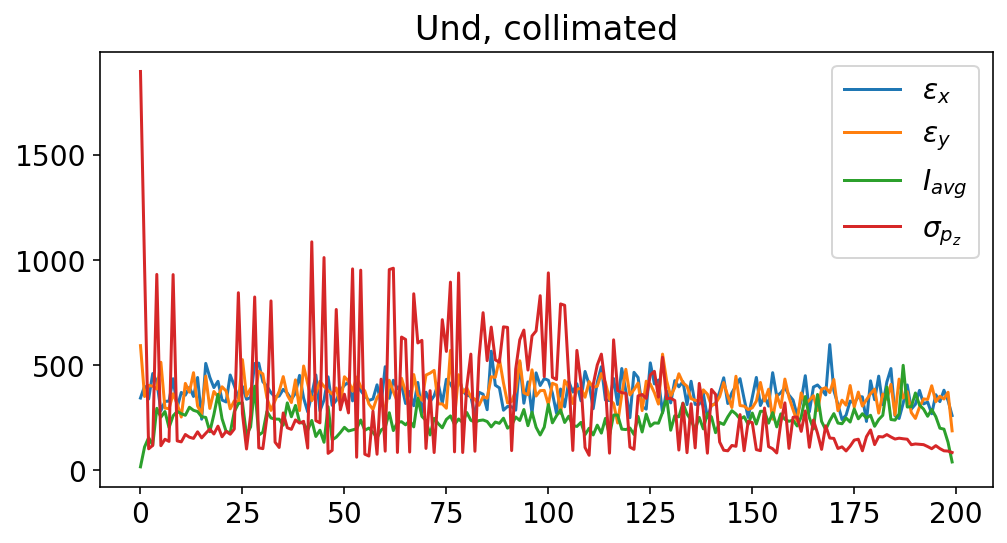

In [7]:
#fig, ax = plt.subplots(3, sharex=True, figsize=(10,13))
sl = slices["HXRSSBEG"]

plt.plot(sl['norm_emit_x']*10**(9), label=r"$\epsilon_x$")
plt.plot(sl['norm_emit_y']*10**(9), label=r"$\epsilon_y$")
plt.plot(sl['average_current']*10**(-1), label=r"$I_{avg}$")
plt.plot(sl['sigma_pz']*10**(-4), label=r"$\sigma_{p_z}$")
plt.title("Und, collimated")

plt.legend()


### energy spread is large because of the weird line shaped horns

In [8]:
sl["sigma_pz"][0]/19 #comparing to old bunches with smaller energy spread

998242.6165916071

## FEL params from bunch/slice statistics


### Initial undulator and beam params
- $K = 3.5$    (  or $  0.934\lambda_u[cm]B_{max}[T]$ )
- $\lambda_{u} = 3$ [cm]  
- $ \lambda_{rad} = \frac{\lambda_{u}}{2\gamma_{rel}^2} (1+\frac{K^2}{2})$ 
- $ K^* = K \Big(j_0\Big(\frac{K^2}{4+2K^2}\Big) - j_1\Big(\frac{K^2}{4+2K^2}\Big)\Big)$

In [9]:
I_A = 17045 # Alfven current [A]

# undulator params
K_u = 3.5 # typical value for LCLS 
lambda_u = 0.03 # m
k_u = 2*np.pi/lambda_u

L_u = 155 # from lattice. Other source: 131.747 # length in m

# coupling 
eta = K_u**2 / ( 4 + 2*K_u**2 )  
JJ = j0(eta) - j1(eta)

In [10]:
z[-3]

136.697

### Functions to calculate FEL parameter and power
Kwang-Je Kim, Phys. Rev. Lett., 57, 1871, (1986)

### $ \rho_{FEL} = \frac{1}{4} \Big[\frac{1}{\pi^2} \frac{I}{17045} \frac{\lambda_u^2}{\gamma_{rel}^3\sigma_{beam}^2} K^{*2} \Big]^{1/3} $

### $ L_{g0} = \frac{1}{4\pi \sqrt{3}} \frac{\lambda_u}{\rho}$

### $L_{g}  =L_{g0}  (1+\Lambda)$

$\Lambda = 0.45\eta_d^{0.57} + 0.55\eta_{\epsilon}^{1.6} + 3\eta_{\gamma}^{2} + 0.35\eta_{\epsilon}^{2.9}\eta_{\gamma}^{2.4} + 51\eta_d^{0.95}\eta_{\gamma}^{3} +5.4\eta_d^{0.7}\eta_{\epsilon}^{1.9} + 1140\eta_d^{2.2}\eta_{\epsilon}^{2.9}\eta_{\gamma}^{3.2}$ 


### $P_{noise} = \frac{6\sqrt{\pi}}{N_{\lambda}\sqrt{\ln(N_{\lambda}/\rho)}}\rho^2P_{beam}$
or
### $P_{noise} = \rho \gamma_0 mc^2 \frac{\sigma_w}{\sqrt{2\pi}}$
with $\sigma_w = \sqrt{\frac{3\sqrt{3}\rho}{k_u z}}\omega_1$

### $P_{beam} = mc^2\gamma I_{beam}/e$ 
### $ P_{rad}(z) \sim \frac{P_{noise}}{9}e^{z/L_g}$
### $P_{sat} = \frac{1.6}{(1+\Lambda)^2}\rho_{FEL} P_{beam}$

In [13]:
def resonantLambda(gamma_beam, K_u, lambda_u):
    return lambda_u * (1 + K_u**2 /2) / (2 * gamma_beam**2)

def rhoFEL(current_beam, sigma_beam, gamma_beam):
    rho = 1/4 * (current_beam/I_A/ np.pi**2 * lambda_u**2/gamma_beam**3/sigma_beam**2 * (K_u*JJ)**2)**(1/3)
    return rho

def gainLength1D(rho, lambda_u):
    return 0.045944074618482676 * lambda_u / rho # prefactor is 1./(4.*np.pi*np.sqrt(3))

def getLambdaMX(Lg1D, sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz):
    # Ming Xie perturbative fitting formula, effects of energy spread, emittance and diffraction
    eta_d = Lg1D/(2*sizes**2)*lambda_rad/(2*np.pi) # OK
    eta_e = 4*np.pi*Lg1D/lambda_rad *emittance /(sizes**2/emittance) # OK
    eta_g = (4*np.pi/lambda_u)*(sig_pz/mean_pz)*Lg1D  # OK
    
    # coefficients
    a = np.array( [0.45, 0.57, 0.55, 1.6, 3., 2., 0.35, 2.9, 2.4, 51.,\
               0.95, 3., 5.4, 0.7, 1.9, 1140., 2.2, 2.9, 3.2] )
    
    LambdaMX = a[0]*(eta_d**a[1]) + a[2]*(eta_e**a[3]) + a[4]*(eta_g**a[5])\
    + a[6]*(eta_e**a[7])*(eta_g**a[8]) + a[9]*(eta_d**a[10])*(eta_g**a[11]) \
    + a[12]*(eta_d**a[13])*(eta_e**a[14]) + a[15]*(eta_d**a[16])*(eta_e**a[17])*(eta_g**a[18])
    
    return LambdaMX

def gainLength(Lg1D, LambdaMX):
    return Lg1D * (1. + LambdaMX)

def Pbeam(gamma_beam, current_beam):
    # kinetic power of e-beam
    # [A] x unitless x [MV] = [MW]
    return m_e * gamma_beam * current_beam / 10**3 # to GeV

def shot_noise(rho, lambda_rad, beam_current, gamma_beam):
    N = (beam_current*lambda_rad/(c*e))    
    beam_power = Pbeam(gamma_beam, beam_current)
    return 6*np.sqrt(np.pi)*rho**2*beam_power/(N*np.sqrt(np.log(N/rho)))

def shot_noise(rho, lambda_rad, gamma_beam, z):
    sig_w = np.sqrt( 3*np.sqrt(3)*rho/k_u/z ) * 2*np.pi*c/lambda_rad
    return rho*gamma_beam*sig_w/np.sqrt(2*np.pi)
    
def Psat(LambdaMX, rho, P_beam):
    return 1.6/(1+LambdaMX)**2 * rho * P_beam 

def Pz(Pnoise, exp_arg):
    return Pnoise/9 * np.exp(exp_arg)


## Find saturation gain length

1. ~~from beta, current, sig_pz, etc -> get instantaneous Lg at marker for each slice (loop over slices)~~
2. ~~from dZ (dist from prev marker) -> get fraction of avg Lg~~
3. ~~go to next marker: repeat (loop over markers)~~
4. ~~mark when 18Lg is reached~~
5. ~~get Psat at 18Lg location~~
6. ~~check how to get slice beta~~
7. ~~check H-D equations: linear growth after Psat~~
8. if not reached, subtract Lg not reached * 1/e from Psat 
9. get spectrum of photon/sec vs energy
10. cross-check final power
11. Note: this does not account for gaps between undulator magnets


In [14]:
P.twiss("x")

{'alpha_x': -4.999331861818694,
 'beta_x': 134.64510956709648,
 'gamma_x': 0.1930505990761035,
 'emit_x': 2.441987712179469e-11,
 'eta_x': 0.0005391412759022698,
 'etap_x': 2.9445014146343527e-05,
 'norm_emit_x': 3.8058313886884313e-07}

In [15]:
# instant growth rate (Lg) at each marker for each slice
lg_slice = []

for i,marker in enumerate(markers):
    
    # particle group/slice
    sl = slices[marker]
    P = P_data[f'{i}_'+marker] 

    # emittances
    norm_emit_x = sl["norm_emit_x"]
    norm_emit_y = sl["norm_emit_y"]
    
    # average current
    current_beam = sl["average_current"]

    # energy spread
    sig_pz = sl["sigma_pz"]/19 # adjusted just to test, take real one here after fixing horns!!!!!!!!!!!!!
    mean_pz = sl["mean_pz"]

    # gamma relativistic
    gamma_beam = sl["mean_pz"]/P.mass 
    
    # normalization factor for each slice ---> is this correct or is it beta*gamma?????????????????????
    norm_fac_mult = gamma_beam 

    # unnormalized emittances
    un_emit_x = norm_emit_x/norm_fac_mult # [m]
    un_emit_y = norm_emit_y/norm_fac_mult
    
    # beam sizes
    sig_x = sl["sigma_x"]
    sig_y = sl["sigma_y"]

    # geom size
    sizes = np.sqrt(sig_x*sig_y) #check for MX assumptions: assymmetric beam size?????????????????????
    
    # geom emittance (not normalized)
    emittance = np.sqrt(un_emit_x * un_emit_y)

    # radiation wavelength
    lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)
    
    # FEL parameter
    rho = rhoFEL(current_beam, sizes, gamma_beam)
    
    # get instant. Lg
    Lg1D = gainLength1D(rho, lambda_u)
    
    # Ming Xie
    LambdaMX = getLambdaMX(Lg1D, sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
    Lg = gainLength(Lg1D, LambdaMX)
    
    # append to list
    lg_slice.append(Lg)

In [16]:
np.array(lg_slice).shape 

(77, 200)

### Find z location reached 18Lg

In [17]:
# Get z distance between markers (dZ)
dZ = [0]*len(z)

for i,loc in enumerate(z):
    dz = loc-z[i-1]
    
    if dz == 0 or i ==0:
        dz = 0 
    dZ[i] = dz

In [18]:
lg_cumul_slice = [] # gain lengths so far for each slice
zsat = [] # z at saturation
zsat_idx = [] # index of z list at saturation

for j in range(n_slice):
    fracLgcum = 0
    satQ = False
    list_lg_cum = [] # for each slice get Lg along z
    
    for i, instLg in enumerate(lg_slice):
        # at this location in und, get number of gain lengths so far
        fracLg = dZ[i]/instLg[j] # dist since last marker in fractions of Lg at this marker
        Lgcum = fracLg + fracLgcum # increment to find 18Lg marker location
        fracLgcum = Lgcum
        list_lg_cum.append(Lgcum)
        
        if fracLgcum > 18 and satQ == False:
            satQ = True
            #print(f"saturated at z = {z[i]}, marker = {markers[i]}")
            zsat.append(z[i])
            zsat_idx.append(i)
            
    lg_cumul_slice.append(list_lg_cum)

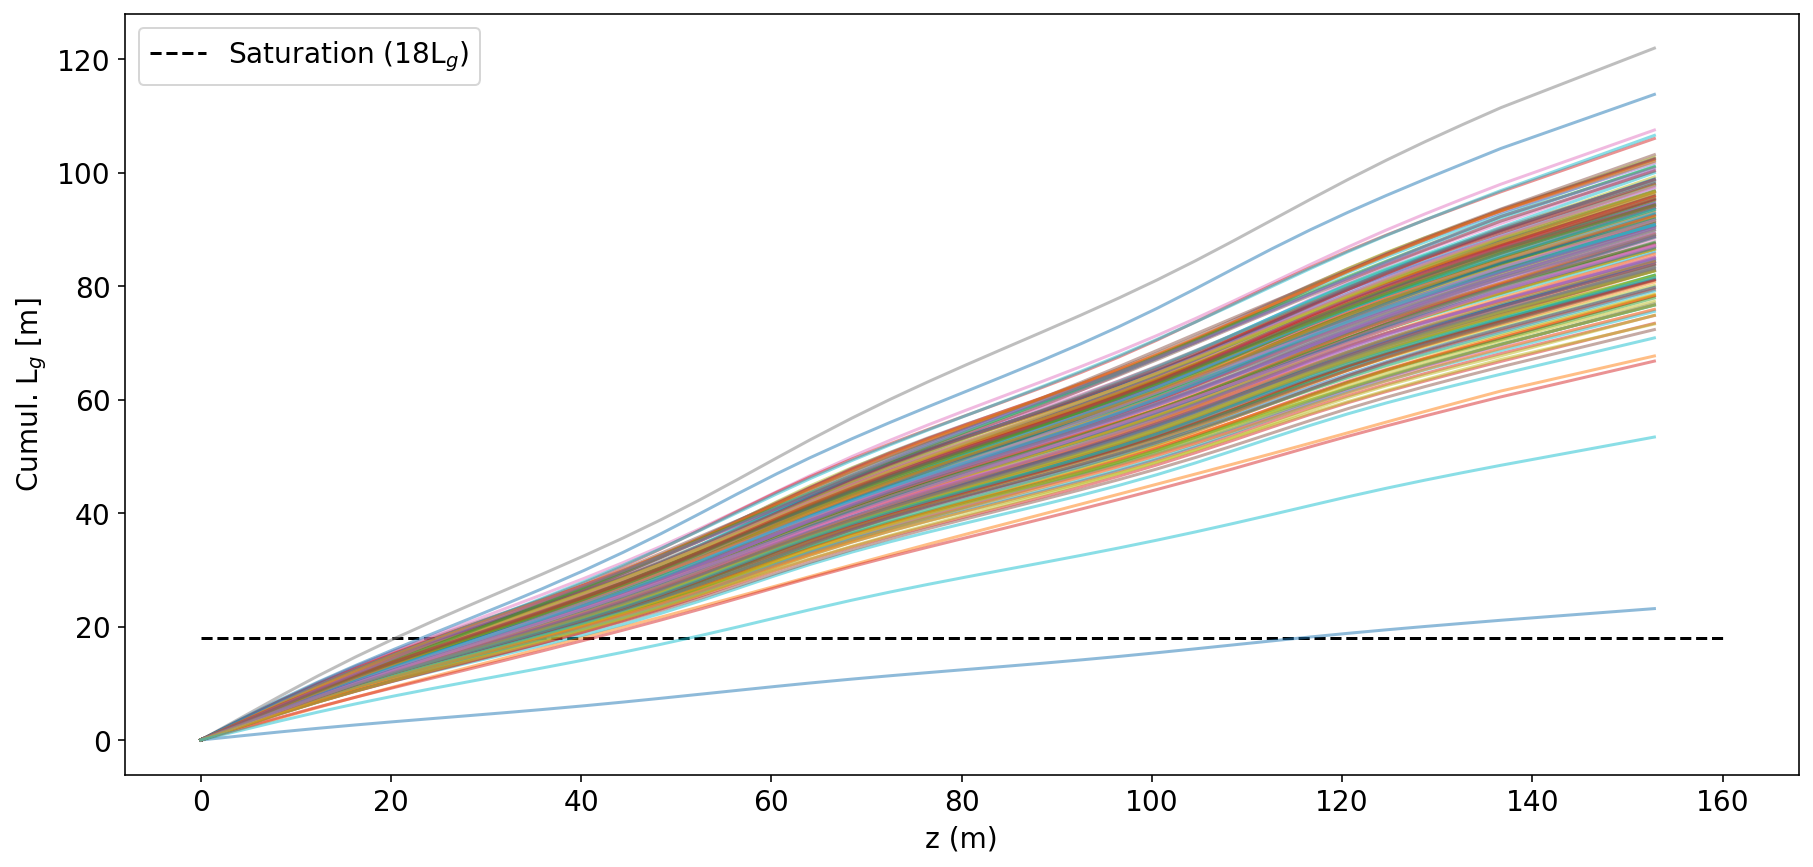

In [19]:
plt.figure(figsize=(15,7))

for i in range(n_slice):
    # plot cumulative Lg for each slice along undulator
    plt.plot(z, lg_cumul_slice[i], alpha=0.5)

# saturation point
plt.hlines(18, 0, 160, linestyle="--", color="black", label="Saturation (18L$_g$)")

plt.legend()
plt.ylabel(r"Cumul. L$_g$ [m]");
plt.xlabel("z (m)");

### if energy spread is too large (>0.012%, towards 0.2%) then FEL does not saturate before 18Lg
not sure what else affects it

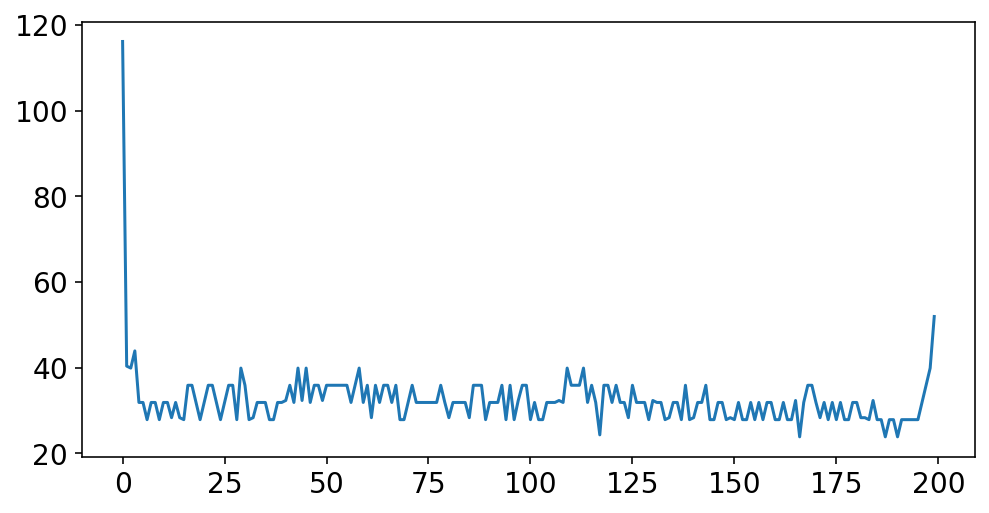

In [20]:
plt.plot(zsat) # z location where each slice reaches saturation

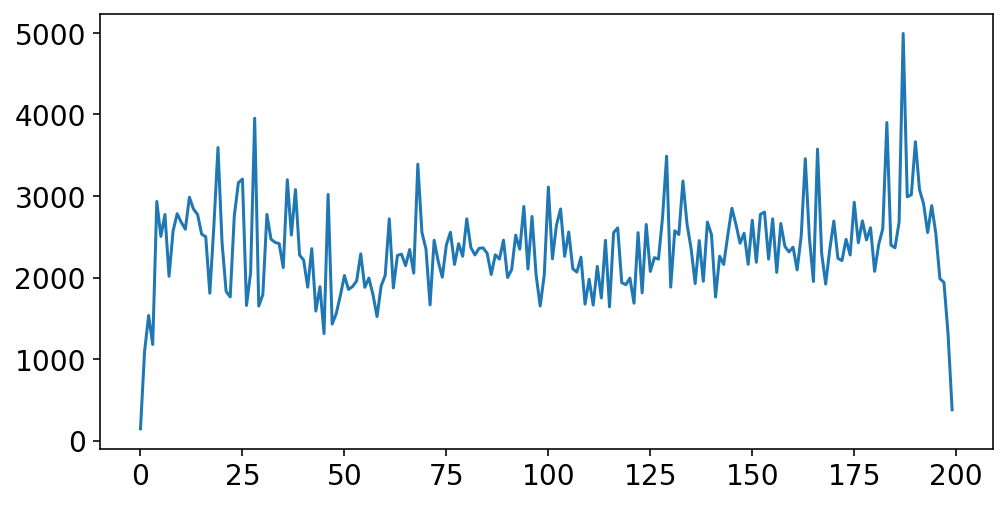

In [21]:
plt.plot(slices["VVHXU46"]['average_current']) # current along bunch at a random spot in undulator

## Find saturation power

In [22]:
# get avg Lg for each slice from saturation point
lg_avg = []

for i in range(n_slice):
    lg_avg.append(zsat[i]/18) # wait is this correct?

In [23]:
p_shotnoise_list, rho_list, psat_list, mean_pz_list, current_list, sizes_list, lambda_rad_list = \
[], [], [], [], [], [], []

# loop over slices at the point where each saturates
for i in range(n_slice):
    # z along und where saturation happens
    sl = slices[markers[zsat_idx[i]]]
    P = P_data[f'{zsat_idx[i]}_'+markers[zsat_idx[i]]] 

    # emittances
    norm_emit_x = sl["norm_emit_x"][i]
    norm_emit_y = sl["norm_emit_y"][i]
    
    # average current
    current_beam = sl["average_current"][i]
    current_list.append(current_beam)

    # energy spread
    sig_pz = sl["sigma_pz"][i]/19 # need to adjust later !!!!!!!!!!!!!!!!!!!!!!
    mean_pz = sl["mean_pz"][i]
    mean_pz_list.append(mean_pz)
    
    # gamma relativistic
    gamma_beam = sl["mean_pz"][i]/P.mass 
    
    # unnormalized emittances
    un_emit_x = norm_emit_x/norm_fac_mult[i] # [m]
    un_emit_y = norm_emit_y/norm_fac_mult[i]
    emittance = np.sqrt(un_emit_x * un_emit_y)
    
    sig_y = sl["sigma_y"][i]
    sig_x = sl["sigma_x"][i]

    sizes = np.sqrt(sig_x*sig_y)
    sizes_list.append(sizes)
    
    # get inst Lg
    lambda_rad = resonantLambda(gamma_beam, K_u, lambda_u)
    lambda_rad_list.append(lambda_rad)
    
    rho = rhoFEL(current_beam, sizes, gamma_beam)
    rho_list.append(rho)
    Lg1D = gainLength1D(rho, lambda_u)
    
    p_shotnoise_list.append(shot_noise(rho, lambda_rad, current_beam, gamma_beam))
    pbeam = Pbeam(gamma_beam, current_beam)
    
    # not sure if correct to us 3DLg in MX factor?
    LambdaMX = getLambdaMX(lg_avg[i], sizes, lambda_rad, emittance, lambda_u, sig_pz, mean_pz)
    Lg = lg_avg[i]
    
    psat_list.append(Psat(LambdaMX, rho, pbeam)) # in GW
    print(Psat(LambdaMX, rho, pbeam), Pz(shot_noise(rho, lambda_rad, current_beam, gamma_beam), 18))

0.025716514115498922 1.8352752957594343e+19
6.8723450745782175 3.269178587660883e+20
11.093301436937532 5.4469898667251034e+20
7.369666142556553 3.446786368154323e+20
25.4343480492462 1.1869426895148126e+21
21.72150194703276 1.0356745889571267e+21
26.69494159521529 1.3481882261470349e+21
17.67270890853397 9.624289370577851e+20
22.259286873042505 1.094930171102116e+21
26.28679188532835 1.2823595302876018e+21
24.138175213935508 1.1734017718261627e+21
22.137237120514282 1.0074371551995303e+21
27.866180200691264 1.3444020313482008e+21
25.371339006377426 1.2291857422961958e+21
25.81419265252111 1.2646400429650016e+21
23.857670212305187 1.20027303665765e+21
19.866246243028854 8.947493151757352e+20
13.936074390096504 6.431168039456355e+20
23.377302251342684 1.1465187605871502e+21
33.49927381390916 1.5011018558521048e+21
20.38931999653499 9.201469707742822e+20
13.353699011518508 5.5955587109711013e+20
13.175236343459408 5.814066188858665e+20
24.876035648373875 1.2049452596192265e+21
28.9148121

In [24]:
min_e = min(mean_pz_list)
max_e = max(mean_pz_list)
(max_e - min_e)/np.mean(mean_pz_list)*100

0.09664495426850862

In [25]:
min_e, max_e

(7975066126.065521, 7982776646.245072)

In [26]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

### Energy binning (electron energy)

In [63]:
bin_size = 5000
bins = create_bins(lower_bound= int(min_e),
                       width=bin_size,
                       quantity= int((max_e-min_e)/bin_size))

In [70]:
binned_psat = [0]*len(bins)
binned_e_phot = [0]*len(bins)
binned_num_phot = [0]*len(bins)
en_idx = []

for i in range(n_slice):
    bin_index = find_bin(mean_pz_list[i], bins)
    en_idx.append(bin_index)

    binned_psat[bin_index] = binned_psat[bin_index] + psat_list[i]
    
#     if slice_energy[bin_index]>80:
#         print(bin_index, current_list[i], psat_list[i], slice_energy[bin_index])

    # photons/sec from power: divide by photon energy [W]/[J]= ph/[s]
    # need photon energy corresponding to each electron energy bin
    binned_e_phot = constants.h*c/(lambda_rad_list[i]) # [J.s]x[m/s]/m
    binned_num_phot[bin_index] = binned_psat[bin_index]*1e9/120 / binned_e_phot + binned_num_phot[bin_index]
    #binned_num_phot[bin_index] = binned_e_phot/constants.h + binned_num_phot[bin_index]
    

In [71]:
len(binned_num_phot)

1543

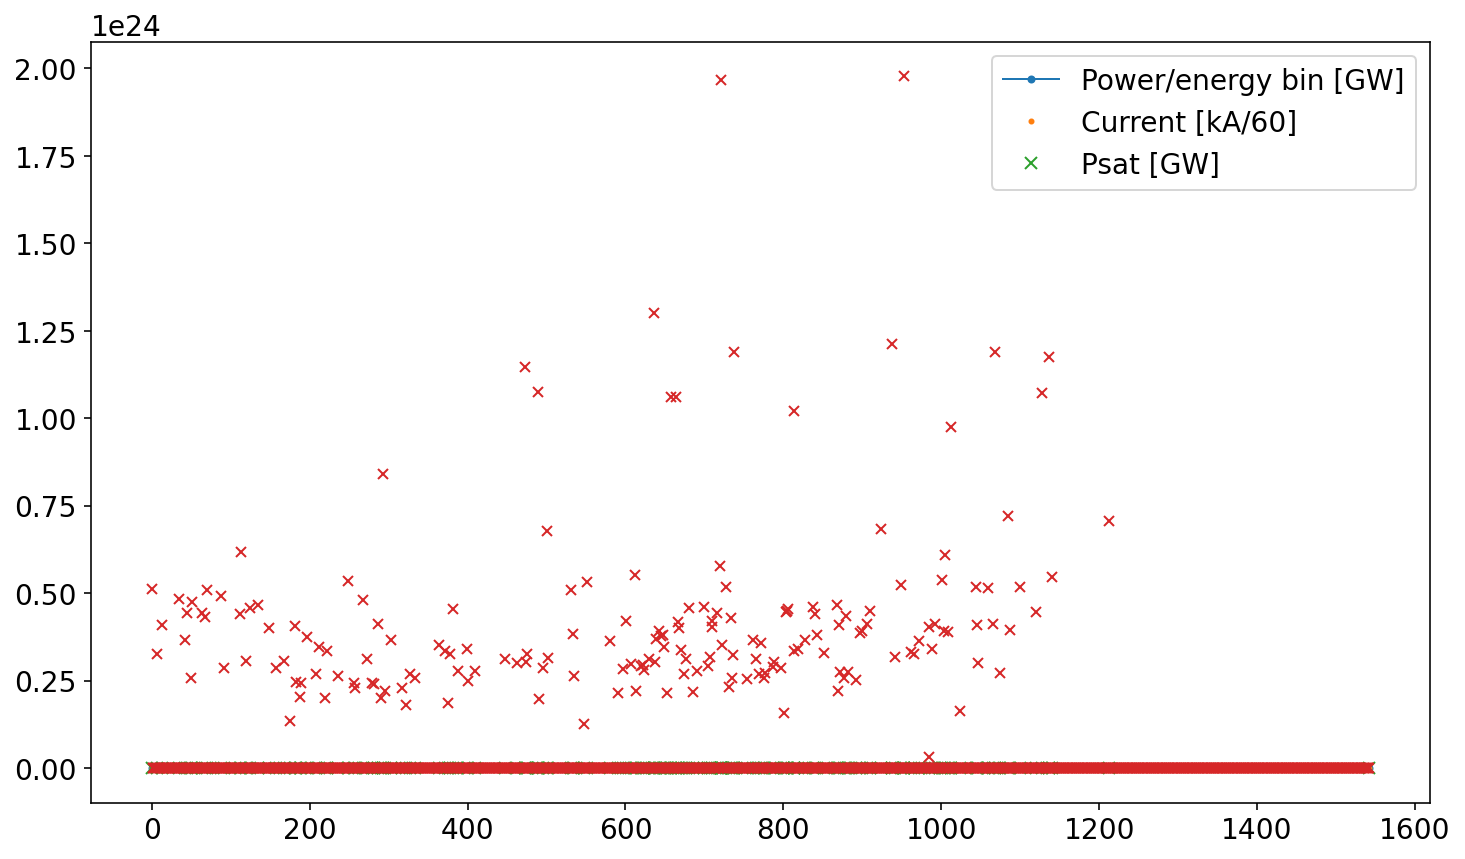

In [72]:
plt.figure(figsize=(12,7))

plt.plot(binned_psat, linewidth=1, marker='.', label="Power/energy bin [GW]")
#plt.ylabel("P/energy bin [GW]")

plt.plot(en_idx, np.array(current_list)/60, linewidth=0, marker='o', markersize=2, label="Current [kA/60]")
plt.plot(en_idx, np.array(psat_list), linewidth=0, marker='x', label="Psat [GW]")

plt.legend()
plt.plot(np.array(binned_num_phot)/1, linewidth=0, marker='x', markersize=5)

# max 0.6-1.3 E17 photons/s -> expected 0.15-14 E12 ---->>> 5 orders of magnitude off

## Random stats

In [32]:
# radiation wavelength
rad_lambda = resonantLambda(gamma_beam, K_u, lambda_u)*1e+9 # expecting ~0.4 nm
rad_lambda

0.4382387598602981

In [33]:
# photon energy
E_ph = hc/(rad_lambda)*1e-3 # eV
E_ph # expecting about 2.7 keV

2.82914725463179

In [34]:
np.mean(psat_list) # per pulse, expected around 24 with taper

19.456799575271955

In [35]:
# energy in joules
keV2J = e*1e3
E_ph *keV2J

4.532793625516302e-16

In [73]:
e

1.602176634e-19

In [38]:
# photons/second
E_ph *keV2J/constants.h

6.840847625973748e+17

# Post-sat peak coherent power per pulse (linear growth after saturation)
Based on Heinz-Dieter "Maximum credible FEL and spontaneous energy per pulse" document,(Appendix A.16)

In [307]:
# find Lg post sat
def LPostSat(L_u, Lg_3D_sat):
    '''Finds und. lenfth after the saturation point.
       Lg_3D_sat is gain length at saturation, L_u is und. length.
    '''
    return max(0, L_u - Lg_3D_sat)

def PeakCohPow():
    '''Peak coherent power per pulse incorporating post-saturation 
    taper enhancement used for SASE nominal operation.
    e_d is the MX diffraction parameter.
    '''
    factor1 = 4.2 / (1+5*e_d)**3 # if not self-seeded
    factor2 = np.log(Lpost_sat/Lg) # if PostSat and Lpostsat > Lg
    
    if Lpost_sat>Lg:
        return (1 + factor1*factor2 ) * psat*np.exp(Lpost_sat/Lg)
    else:
        return psat*np.exp(Lpost_sat/Lg)

incorporate this calc. after saturation:
- add MX calc at each point
- get Lg
- get e_d

backoff: multiply by 1/ e**(n_missed